In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data Exploration

In [2]:
train_data = pd.read_csv('drugsComTrain_raw.tsv', sep='\t', index_col=0)
train_data.head()

,drugName,condition,review,rating,date,usefulCount
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [6]:
print('train data size: ', train_data.shape)

train data size:  (161297, 6)


unique class of drug:  3436


(0, 2000)

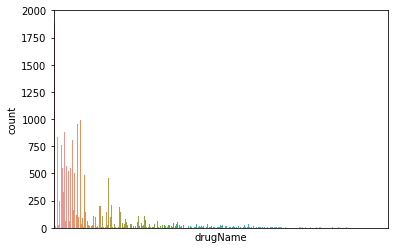

In [7]:
# 很粗略的看一下藥的分布情況，因為有點太多種了所以不是很清楚，
# 但仍可以清楚看到有幾種藥物出現的特別多次
print('unique class of drug: ', len(np.unique(train_data.drugName)))
ax = sns.countplot(x="drugName", data=train_data)
ax.set_xticks([])
ax.set_ylim(0,2000)

In [8]:
train_data.condition = train_data.condition.apply(lambda x: str(x))
print('unique class of condition: {}'.format(len(np.unique(train_data.condition))))

unique class of condition: 885


(0, 6000)

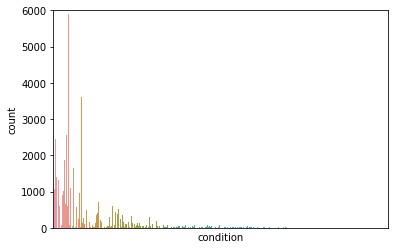

In [9]:
# Condition 分布不均的狀況更明顯
ax = sns.countplot(x="condition", data=train_data)
ax.set_xticks([])
ax.set_ylim(0,6000)

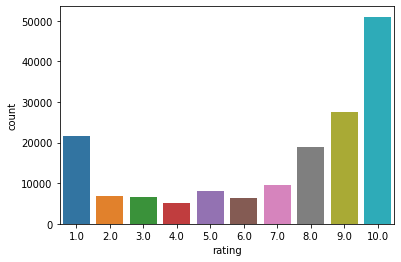

In [10]:
# 評等以最高和最低的極端情形最多，中間值的分布還頗平均
ax = sns.countplot(x="rating", data=train_data)

# Data Preprocessing
### Remove Stopword & Punctuation

In [11]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) | set(string.punctuation)

In [12]:
tokens = []
sentences = []
for i, r in train_data.iterrows():
    filtered = [w.lower() for w in word_tokenize(r.review) if w not in stop_words]
    tokens.append(filtered)
    sentences.append(" ".join(filtered))

### CountVectorizer

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score
cv = CountVectorizer()
train_X = cv.fit_transform(sentences)
train_y = train_data['rating'].to_numpy()
print('size of train_X: {}, size of train_y: {}'.format(train_X.shape, len(train_y)))

size of train_X: (161297, 49891), size of train_y: 161297


In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=0, class_weight="balanced")
rfc.fit(train_X, train_y)
train_acc = rfc.score(train_X, train_y)
train_y_hat = rfc.predict(train_X)
train_f1 = f1_score(train_y, train_y_hat, average='macro')
print('Accuracy on training set: {}'.format(train_acc))
print('F1 score on training set: {}'.format(train_f1))

Accuracy on training set: 0.36130244207889795
F1 score on training set: 0.22550524853176168


### TfidfVectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfv = TfidfVectorizer(min_df=3)
train_X = tfv.fit_transform(sentences)
print('size of train_X: {}, size of train_y: {}'.format(train_X.shape, len(train_y)))

size of train_X: (161297, 24881), size of train_y: 161297


In [16]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=0, class_weight="balanced")
rfc.fit(train_X, train_y)
train_acc = rfc.score(train_X, train_y)
train_y_hat = rfc.predict(train_X)
train_f1 = f1_score(train_y, train_y_hat, average='macro')
print('Accuracy on training set: {}'.format(train_acc))
print('F1 score on training set: {}'.format(train_f1))

Accuracy on training set: 0.3535279639422928
F1 score on training set: 0.22518709683738916


### Word2Vec
這邊想用 gensim 來 train 自己的 word vector，讓文字向量之間能有一些語意上的關聯性

In [17]:
from gensim.models import word2vec
model = word2vec.Word2Vec(tokens, size=100, window=10)
model.save('word.model')

In [27]:
# model = word2vec.Word2Vec.load('word.model')

In [18]:
def get_sentance_feature(model, sentence):
    '''
    對於一句話而言，把一句話中的所有字所對應的向量平均起來，得到整句話的向量
    '''
    featureVec = np.zeros(100, dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)

    for word in sentence:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec, model.wv[word])

    featureVec = np.divide(featureVec, nwords)
    return featureVec

# 把原始的句子轉為句子向量
sent_X = []
for i in tokens:
    sent_feature = get_sentance_feature(model, i)
    sent_feature[np.isnan(sent_feature)] = 0
    sent_X.append(sent_feature)
sent_X = np.array(sent_X)
sent_X.shape

(161297, 100)

In [19]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=0, max_iter=300)
mlp.fit(sent_X, train_y)
train_acc = mlp.score(sent_X, train_y)
train_y_hat = mlp.predict(sent_X)
train_f1 = f1_score(train_y, train_y_hat, average='macro')
print('Accuracy on training set: {}'.format(train_acc))
print('F1 score on training set: {}'.format(train_f1))

C:\Users\Yao\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy on training set: 0.44924580122382934
F1 score on training set: 0.23124694673465437


### Add more features
單純使用 word2vec 好像沒有得到非常顯著的提升，因此我把 usefulCount 這個特徵加進來，並且使用兩層的 MLP 來訓練看看，發現結果提升許多

In [24]:
# 訓練 MLP 需要花點時間，我把訓練完的結果存起來，訓練本身註解掉
X_train = np.concatenate((sent_X, train_data.usefulCount.values.reshape((-1, 1))), axis=-1)
mlp = MLPClassifier(hidden_layer_sizes=(256,100), random_state=0, max_iter=1000)
mlp.fit(X_train, train_y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(256, 100), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [20]:
import pickle
with open('mlp.pickle', 'rb') as f:
    mlp = pickle.load(f)

In [25]:
train_acc = mlp.score(X_train, train_y)
train_y_hat = mlp.predict(X_train)
train_f1 = f1_score(train_y, train_y_hat, average='macro')
print('Accuracy on training set: {}'.format(train_acc))
print('F1 score on training set: {}'.format(train_f1))

Accuracy on training set: 0.6757782227815768
F1 score on training set: 0.6145623986940976


In [26]:
# 儲存 MLP 模型，註解掉避免被覆寫
# import pickle
# with open('mlp.pickle', 'wb') as f:
#     pickle.dump(mlp, f)

### Apply on Testing Set

In [28]:
test_data = pd.read_csv('drugsComTest_raw.tsv', sep='\t', index_col=0)
test_data.head()

,drugName,condition,review,rating,date,usefulCount
163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10.0,"February 28, 2012",22
206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8.0,"May 17, 2009",17
159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9.0,"September 29, 2017",3
39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9.0,"March 5, 2017",35
97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9.0,"October 22, 2015",4


In [29]:
test_tokens = []
test_sentences = []
for i, r in test_data.iterrows():
    filtered = [w.lower() for w in word_tokenize(r.review) if w not in stop_words]
    test_tokens.append(filtered)
    test_sentences.append(" ".join(filtered))

In [30]:
test_y = test_data['rating'].to_numpy()
print('size of test_X: {}, size of test_y: {}'.format(test_data.shape, len(test_y)))

size of test_X: (53766, 6), size of test_y: 53766


In [31]:
test_X = []
for i in test_tokens:
    sent_feature = get_sentance_feature(model, i)
    sent_feature[np.isnan(sent_feature)] = 0
    test_X.append(sent_feature)
test_X = np.array(test_X)
test_X.shape

(53766, 100)

In [32]:
test_X = np.concatenate((test_X, test_data.usefulCount.values.reshape((-1, 1))), axis=-1)

In [35]:
test_acc = mlp.score(test_X, test_y)
test_y_hat = mlp.predict(test_X)
test_f1 = f1_score(test_y, test_y_hat, average='macro')
print('Accuracy on training set: {}'.format(test_acc))
print('F1 score on training set: {}'.format(test_f1))

Accuracy on training set: 0.4801919428635197
F1 score on training set: 0.3622647381065494
